# Import the necessary dependencies 

### Setting TensorFlow 2.x as default version 

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

### Importing the Visualisation and Preprocessing packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import cv2

import numpy as np
import pandas as pd
import pickle

import random


### Importing the TensorFlow dependencies

In [3]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Data loading and Visualisation 

### Loading the data

In [11]:
#data = pd.read_csv("german-traffic-signs / signnames.csv") 
  
with open('C:\\Users\\saivi\\Desktop\\TRAIN 5\\dataset\\train.p', 'rb') as f: 
    train_data = pickle.load(f) 
with open('C:\\Users\\saivi\\Desktop\\TRAIN 5\\dataset\\valid.p', 'rb') as f: 
    val_data = pickle.load(f) 
with open('C:\\Users\\saivi\\Desktop\\TRAIN 5\\dataset\\test.p', 'rb') as f: 
    test_data = pickle.load(f) 

# Extracting the labels from the dictionaries 
x_train, y_train = train_data['features'], train_data['labels'] 
x_val, y_val = val_data['features'], val_data['labels'] 
x_test, y_test = test_data['features'], test_data['labels'] 

print(x_train.shape) 
print(x_val.shape) 
print(x_test.shape) 

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


### Visualising the Image data

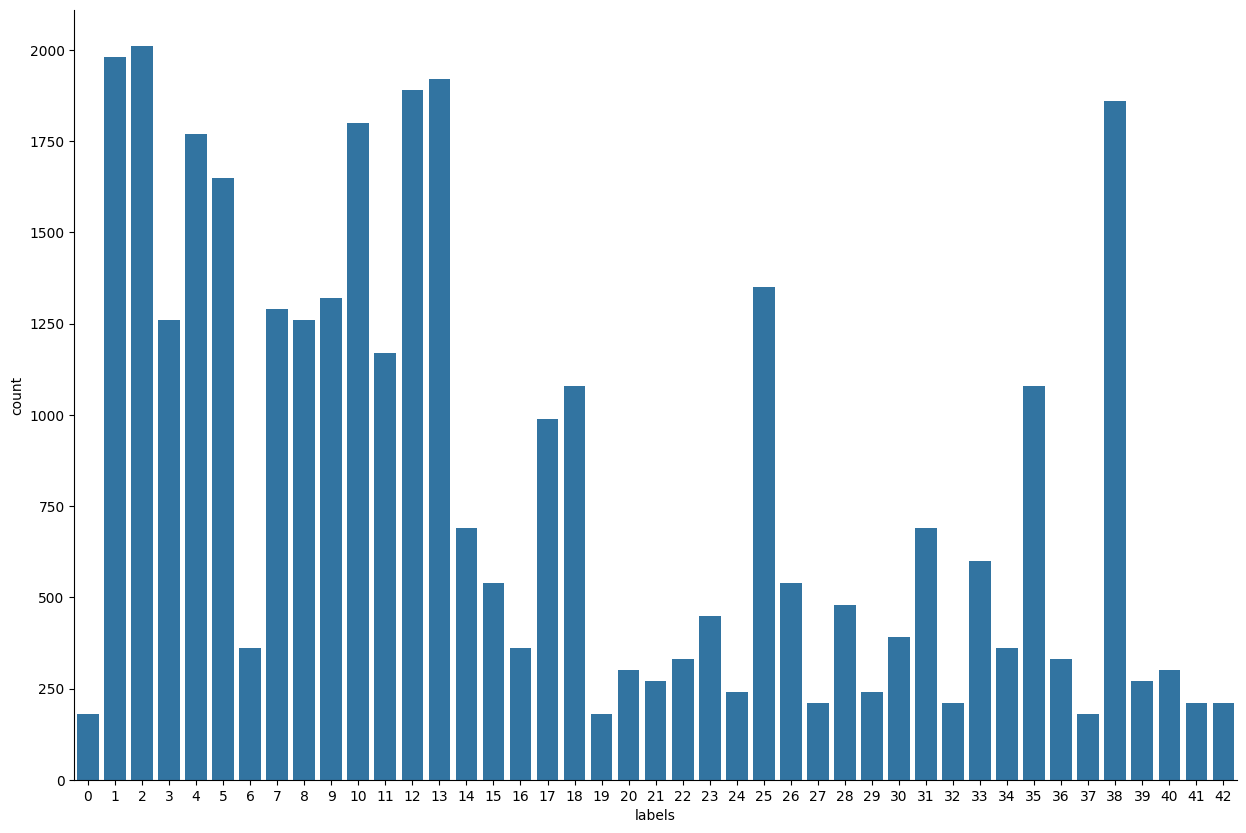

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.countplot(x="labels", data=train_data)
sns.despine()

# Image Processing & Image Augmentation

### Pre-processing the images using OpenCV

In [9]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
x_train_final = np.array(list(map(preprocessing, x_train))) 
x_val_final = np.array(list(map(preprocessing, x_val))) 
x_test_final = np.array(list(map(preprocessing, x_test))) 
  
x_train_final = x_train_final.reshape(34799, 32, 32, 1) 
x_val_final = x_val_final.reshape(4410, 32, 32, 1) 
x_test_final = x_test_final.reshape(12630, 32, 32, 1) 


### Image Augmentation using ImageDataGenerator

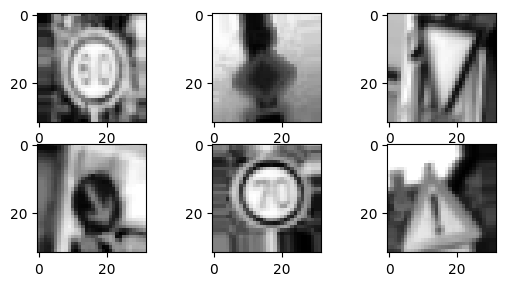

In [14]:

datagen = ImageDataGenerator(width_shift_range = 0.1,  
                  height_shift_range = 0.1,  
                  zoom_range = 0.2,  
                  shear_range = 0.1,  
                  rotation_range = 10) 

datagen.fit(x_train_final) 

#os.makedirs('/content/drive/My Drive/Traffic_sign_Dataset/images')

for x_batch,y_batch in datagen.flow(x_train_final,y_train,batch_size=6,save_to_dir='C:\\Users\\saivi\\Desktop\\TRAIN 5\\dataset',save_prefix='img', save_format='jpg'):
    for i in range(0, 6):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))

    plt.show()
    break

y_train = to_categorical(y_train, 43) 
y_val = to_categorical(y_val, 43) 
y_test = to_categorical(y_test, 43) 


# Model Building and Testing 

### Implementing the CNN Model 

In [15]:
def build_model(hp):
    model = Sequential()

    # Layer 1 
    model.add(Conv2D(filters=hp.Int('CONV_1_FILTER',min_value=32, max_value=64),
                     kernel_size=hp.Choice('KERNEL_1_FILTER', values=[3,5]),
                     activation='relu',
                     input_shape=(32,32,1), 
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_1', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    # Layer 2 
    model.add(Conv2D(filters=hp.Int('CONV_2_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_2_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


    # Layer 3
    model.add(Conv2D(filters=hp.Int('CONV_3_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_3_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_3', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    model.add(Flatten())

    
    model.add(Dense(hp.Int('DENSE_1_LAYER', 
                           min_value=32, 
                           max_value=512),
                    
                    activation = hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
    ))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    model.add(Dense(43, activation='softmax'))

    # Learning Rate set between 0.0001 to 0.01
    model.compile(Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG')),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

### Install Kerastuner

In [16]:
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/b3/fb/35dab32ffc45faefcb6762088a1c105e421fbd253eb3e86002b70916e6f3/keras_tuner-1.4.4-py3-none-any.whl.metadata
  Obtaining dependency information for keras-core from https://files.pythonhosted.org/packages/95/f7/b8dcff937ea64f822f0d3fe8c6010793406b82d14467cd0e9eecea458a40/keras_core-0.1.7-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/101.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/101.3 kB ? eta -:--:--
     ----------- --------------------------- 30.7/101.3 kB 1.3 MB/s eta 0:00:01
     -------------- ---------------------- 41.0/101.3 kB 487.6 kB/s eta 0:00:01
     -------------- ---------------------- 41.0/101.3 kB 487.6 kB/s eta 0:00:01
     ------------------------------------ 101.3/101.3 kB 646.1 kB/s eta 0:00:00
   ---------------------------------------- 

### Use RandomSearch using keraatuner to find the best hyperparameters

In [17]:
from kerastuner import RandomSearch

Using TensorFlow backend


C:\Users\saivi\AppData\Local\Temp\ipykernel_6588\659161079.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [23]:
tuner = RandomSearch(build_model, objective='val_accuracy',
                     max_trials = 10, 
                     directory='C:\\Users\\saivi\\Desktop\\TRAIN 5\\dataset',
                     project_name="Traffic_Sign_Classifier")

tuner.search_space_summary()

In [27]:
tuner.search(x_train_final,y_train,epochs=10, validation_data=(x_val_final,y_val))

Trial 10 Complete [00h 18m 51s]
val_accuracy: 0.9185941219329834

Best val_accuracy So Far: 0.9696145057678223
Total elapsed time: 02h 10m 02s


### Get the best model

In [28]:
final_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        480       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 92)        110492    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 92)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 92)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 127)         2

### Creating a Model Checkpoint

In [30]:
filepath="C:\\Users\\saivi\\Desktop\\TRAIN 5\\Traffic_Sign_Classifier-with-Streamlit-master\\Model\\Traffic_Sign_Classifier_CNN.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]

### Fit the model

In [31]:
BATCH_SIZE = 100
EPOCHS = 40

In [32]:
history = final_model.fit(
                            datagen.flow(x_train_final, y_train, batch_size=BATCH_SIZE), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(BATCH_SIZE))), 
                            epochs = EPOCHS, 
                            validation_data =(x_val_final, y_val),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )


Epoch 1/40
348/348 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.8079
Epoch 1: val_accuracy improved from -inf to 0.97755, saving model to C:\Users\saivi\Desktop\TRAIN 5\Traffic_Sign_Classifier-with-Streamlit-master\Model\Traffic_Sign_Classifier_CNN.hdf5
348/348 [==============================] - 53s 147ms/step - loss: 0.7973 - accuracy: 0.8079 - val_loss: 0.2471 - val_accuracy: 0.9776
Epoch 2/40


C:\Users\saivi\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


348/348 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.8728
Epoch 2: val_accuracy did not improve from 0.97755
348/348 [==============================] - 50s 144ms/step - loss: 0.5609 - accuracy: 0.8728 - val_loss: 0.2403 - val_accuracy: 0.9739
Epoch 3/40
348/348 [==============================] - ETA: 0s - loss: 0.4942 - accuracy: 0.8926
Epoch 3: val_accuracy did not improve from 0.97755
348/348 [==============================] - 49s 140ms/step - loss: 0.4942 - accuracy: 0.8926 - val_loss: 0.2530 - val_accuracy: 0.9698
Epoch 4/40
348/348 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.9076
Epoch 4: val_accuracy improved from 0.97755 to 0.97914, saving model to C:\Users\saivi\Desktop\TRAIN 5\Traffic_Sign_Classifier-with-Streamlit-master\Model\Traffic_Sign_Classifier_CNN.hdf5
348/348 [==============================] - 49s 142ms/step - loss: 0.4468 - accuracy: 0.9076 - val_loss: 0.2250 - val_accuracy: 0.9791
Epoch 5/40
348/348 [===========

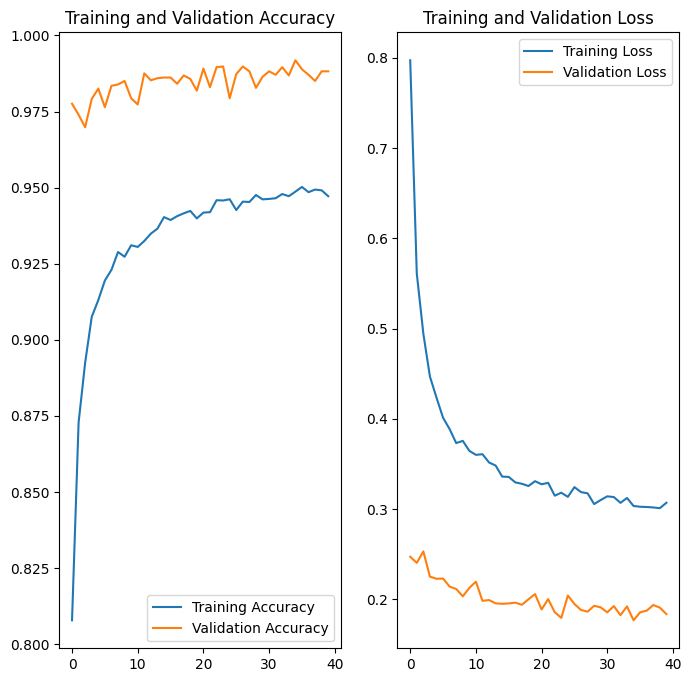

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Load the model's weights and biases for evaluation on Test set

In [34]:
final_model.load_weights("C:\\Users\\saivi\\Desktop\\TRAIN 5\\Traffic_Sign_Classifier-with-Streamlit-master\\Model\\Traffic_Sign_Classifier_CNN.hdf5")
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
Pred_conv = final_model.evaluate(x_test_final, y_test, verbose=0)
print("Results on the test data")
print(" ")
print("%s- %.2f" % (final_model.metrics_names[0], Pred_conv[0]))
print("%s- %.2f" % (final_model.metrics_names[1], Pred_conv[1]))

Results on the test data
 
loss- 0.27
accuracy- 0.97


### Testing the model on the test dataset

1/1 [==============================] - 0s 51ms/step
Predicted sign: [[1.04573544e-10 4.20667766e-06 7.60974999e-08 1.05248645e-07
  6.43160039e-11 3.52476163e-05 9.99958158e-01 8.15450996e-09
  1.15185465e-10 1.85953819e-13 4.11649501e-13 2.18767129e-10
  7.03435053e-12 2.77545998e-12 3.32493934e-13 3.02837529e-12
  3.02511100e-10 1.60662075e-14 7.75681862e-12 1.34260936e-11
  4.28727193e-11 6.93445718e-11 2.11512977e-13 3.37022315e-12
  1.06438721e-11 4.71293282e-11 1.42021854e-12 1.76048620e-11
  2.12260140e-10 7.66987515e-11 3.73480979e-09 4.20353856e-11
  4.35604761e-08 4.96415246e-13 5.93739359e-13 1.66539823e-13
  7.39316702e-13 2.01869511e-12 1.61608116e-10 3.58474708e-11
  2.76721313e-09 4.25157012e-08 2.10629423e-06]]
---------------------------------------------------------------------------
1/1 [==============================] - 0s 33ms/step
Predicted Sign[[9.9690443e-01 4.0443608e-04 1.7987539e-08 5.0839710e-10 1.3280325e-03
  2.9693737e-08 9.7685519e-11 1.7067655e-06 1.361

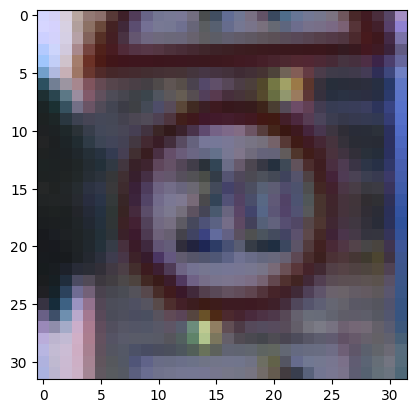

In [38]:

plt.imshow(x_test[990]) 
print("Predicted sign: "+ str( 
        final_model.predict(x_test_final[1700].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(final_model.predict(x_test_final[990].reshape(1, 32, 32, 1))))


### Save the model

In [43]:
final_model.save('C:\\Users\\saivi\\Desktop\\TRAIN 5\\Traffic_Sign_Classifier-with-Streamlit-master\\Model\\Traffic_Sign_Classifier_CNN.hdf5')

C:\Users\saivi\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Loading the saved model 

In [44]:
loaded_model = tf.keras.models.load_model('C:\\Users\\saivi\\Desktop\\TRAIN 5\\Traffic_Sign_Classifier-with-Streamlit-master\\Model\\Traffic_Sign_Classifier_CNN.hdf5')

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 35)        350       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 35)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 35)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 77)        24332     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 77)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 77)          0

### Making predictions with the loaded model 

1/1 [==============================] - 0s 33ms/step


Predicted sign: [[5.3435269e-08 1.1452379e-04 8.0227019e-04 6.3769903e-04 9.7401153e-07
  9.9190569e-01 1.1437065e-06 6.5132515e-03 2.2391929e-05 1.0699004e-08
  1.4233278e-06 7.7431078e-10 4.3745874e-09 2.1988572e-10 2.0122388e-10
  1.0536553e-07 5.5210592e-09 4.1413743e-12 2.9715685e-12 8.8899492e-11
  3.6959169e-10 2.5715732e-10 1.2917930e-11 1.2270499e-11 5.3191374e-10
  5.5049233e-11 1.2248940e-11 4.2230395e-12 7.6508838e-10 6.6626158e-09
  1.9835923e-08 2.2441425e-10 1.6363545e-09 3.3330586e-10 1.6496605e-09
  2.2624784e-09 3.5613845e-11 4.3738065e-11 5.7591027e-08 7.2306772e-11
  6.4404972e-08 4.1097594e-11 2.8846335e-07]]
---------------------------------------------------------------------------
1/1 [==============================] - 0s 27ms/step
Predicted Sign[[5.3435269e-08 1.1452379e-04 8.0227019e-04 6.3769903e-04 9.7401153e-07
  9.9190569e-01 1.1437065e-06 6.5132515e-03 2.2391929e-05 1.0699004e-08
  1.4233278e-06 7.7431078e-10 4.3745874e-09 2.1988572e-10 2.0122388e-10
  1.

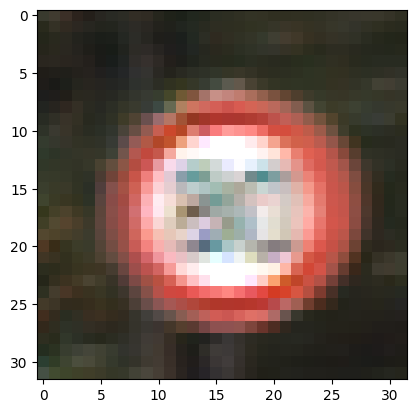

In [46]:
plt.imshow(x_test[1832]) 
print("Predicted sign: "+ str( 
        loaded_model.predict(x_test_final[1832].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(loaded_model.predict(x_test_final[1832].reshape(1, 32, 32, 1))))

### Testing our saved model on random traffic sign images





In [57]:
import cv2
import os
import numpy as np

# Directory containing the images
image_directory = 'C:\\Users\\saivi\\Desktop\\TRAIN 5\\Traffic_Sign_Classifier-with-Streamlit-master\\Test Random Images'

# List all files in the directory
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Load and process each image
for image_file in image_files:
    # Construct the full path to the image
    image_path = os.path.join(image_directory, image_file)

    # Read the image
    img = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if img is not None:
        # Convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Normalize and resize the image
        img = img / 255
        img = cv2.resize(img, (32, 32))

        # Reshape for model input
        img = np.reshape(img, [1, 32, 32, 1])

        # Make predictions
        classes = final_model.predict(img)
        print(f"Image: {image_file}, Class: {classes[0]}")
    else:
        print(f"Failed to load the image: {image_file}")


1/1 [==============================] - 0s 125ms/step
Image: 80 ends.jpg, Class: [6.6018481e-05 3.8274853e-03 4.1507315e-04 1.9806670e-02 6.5663558e-06
 1.3250534e-03 9.6211183e-01 2.4581882e-06 2.5828995e-06 1.2912275e-06
 1.9437859e-06 7.2944960e-05 1.7985826e-08 3.9419597e-03 2.5149398e-06
 6.5551621e-06 2.1128994e-06 3.7116185e-10 9.1981317e-05 2.9699071e-04
 3.9264696e-06 2.2868083e-04 8.2266666e-08 2.1804557e-05 2.7370268e-06
 1.6185577e-05 6.7445922e-06 2.9241164e-06 6.2715367e-06 3.2482840e-05
 1.7678671e-04 2.6420138e-03 9.8257033e-06 1.9351370e-08 1.3444125e-07
 3.6785892e-08 4.6977662e-09 1.3979037e-07 1.5687772e-06 2.0913996e-05
 2.9213345e-06 4.7608367e-03 8.0895021e-05]
1/1 [==============================] - 0s 22ms/step
Image: Ahead only.jpg, Class: [4.1881746e-13 2.6396496e-10 6.8233391e-11 5.3800853e-12 1.3816022e-11
 2.5515316e-13 4.7908883e-13 1.4208274e-12 8.6888309e-15 2.6306804e-12
 2.0227673e-13 2.7016068e-11 1.3593493e-12 7.7962315e-14 1.6333923e-12
 2.3199140e-1